<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning/blob/master/Cartpole_REINFORCE_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 
Use the cartpole environment from Open AI gym (Brockman et al., 2016). Set the discount factor γ to 0.9.  
• REINFORCE algorithm (Williams, 1992) with a two layered MLP to learn the task.  
• Results in a plot, showing on the x-axis the episode count and on the y-axis the episode length (train until convergence). Run on 5 different seeds/runs. The resultant plots will be averaged over these 5 independent seeds. Also show the confidence interval (using the standard deviation obtained from the seeds/runs - you may use fill between from matplotlib).  
• Actor-critic method. Use critic network along with the policy network to learn the optimal behaviour. In critic network, the value function is learnt through bootstrapping. Compare the actor-critic performance against REINFORCE in a single plot.  
• Observations



In [0]:
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.get_logger().setLevel('INFO')

tf.__version__

'2.1.0'

# Policy Gradient

## Algorithm

Input a differentiable policy parameterization $\pi(a \mid s, \theta)$ 
Define step-size $\alpha > 0$  
Initialize policy parameters $\theta \in \rm I\!R^d$. 
Loop through $n$ episodes (or forever):  
Loop through $N$ batches:    
Generate an episode $S_0, A_0, R_1…,S_{T-1},A_{T-1}, R_T$, following $\pi(a \mid s, \theta)$  
For each step $t=0,…T-1$:  
$G_t \leftarrow \sum_{k=t+1}^{T} \gamma^{k-t-1} R_k$  
At the end of each batch of episodes:  
Calculate the loss   
$L(\theta) = -\frac{1}{N} \sum_t^T ln(\gamma^t G_t \pi(A_t \mid S_t, \theta))$  
Update policy parameters through backpropagation:   
$\theta := \theta + \alpha \nabla_\theta L(\theta)$  


The original formula here has a $\gamma$ in the loss/gradient update step but that can be avoided because we dont really need to discount future gradients. This seemed to work better in our case. Sergey Levine has a discussion on this [here](https://www.youtube.com/watch?v=PpVhtJn-iZI&feature=youtu.be&t=33m38s)  


## Code

*Practically, few changes were made in the above algorithm to implement this.*   

*   Used cross entropy loss for negative log likelihood to give similar weights updates as above.  
*   Used a batch of episodes to make the update instead of updating every step. 
*   The discounting rewards are multiplied to the gradient before updation.


In [0]:
class Actor():
  def __init__(self, hidden_size, lr):
    self.model = tf.keras.Sequential()
    for i in range(len(hidden_size)):
      self.model.add(tf.keras.layers.Dense(hidden_size[i], input_dim = 4, activation='relu', dtype='float64'))
    self.model.add(tf.keras.layers.Dense(2, dtype='float64'))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    self.model.build()

  def compute_loss(self, selected_action, logits):
    actions_one_hot = tf.one_hot([selected_action], 2)
    negative_loglikelihoods = tf.nn.softmax_cross_entropy_with_logits(labels=actions_one_hot, logits=logits)
    # Below step is instead completed by multiplying gradients with discounted_rewards
    # weighted_negative_loglikelihoods = tf.math.multiply(negative_loglikelihoods*discounted_rewards)
    loss = tf.reduce_sum(negative_loglikelihoods)
    return loss

  def init_grad_memory(self):
    grad_memory = self.model.trainable_variables
    for i, grad in enumerate(grad_memory):
      grad_memory[i] = grad * 0
    return grad_memory

  def discount_rewards(self, r, gamma):
      discounted_r = np.zeros_like(r)
      running_add = 0
      for t in reversed(range(0, r.size)):
          running_add = running_add * gamma + r[t]
          discounted_r[t] = running_add
      return discounted_r

In [0]:
def policy_gradient(seed, actor, n_episodes, gamma, batch_size):
  env = gym.make('CartPole-v0')
  action_size = 2

  env.seed(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)

  e_scores = []
  actor_grad_memory = actor.init_grad_memory()

  for episodes in range(n_episodes):
    
    s = env.reset()
    memory = []
    cum_score = 0
    done = False 
    while not done: 
      s = s.reshape([1,4])
      with tf.GradientTape() as tape:
        logits = actor.model(s)
        probs = tf.nn.softmax(logits)
        action = np.random.choice(action_size, p=probs.numpy()[0])
        loss = actor.compute_loss(action, logits)

      # Making a step in the action selected
      s, r, done, _ = env.step(action)
      cum_score += r

      grads = tape.gradient(loss, actor.model.trainable_variables)
      memory.append([grads,r])
      
    e_scores.append(cum_score)
    memory = np.array(memory)

    # Discounting the rewards and multiplying with gradients later 
    memory[:,1] = actor.discount_rewards(memory[:,1], gamma)
    
    # Weighting the gradients with discounted rewards
    for grads, G in memory:
      for i,grad in enumerate(grads):
        actor_grad_memory[i] +=  grad * G 
    
    # Updating weights once the batch is filled
    if episodes % batch_size == 0:
      actor.optimizer.apply_gradients(zip(actor_grad_memory,
                                          actor.model.trainable_variables))
      actor_grad_memory = actor.init_grad_memory()
        
    if episodes % 100 == 0:
      print("Episode  {}  Score  {}".format(episodes, np.mean(e_scores[-100:])))

  return e_scores

In [0]:
final_score_policy_gradient = []
for i in [1, 100, 345, 768, 123]:
  actor = Actor(hidden_size=[64], lr = 0.01)
  print("Seed", i)
  score = policy_gradient(i, actor, n_episodes=2000, gamma=0.99, batch_size=5)
  final_score_policy_gradient.append(score)

Seed 1
Episode  0  Score  16.0
Episode  100  Score  58.27
Episode  200  Score  152.7
Episode  300  Score  195.08
Episode  400  Score  188.76
Episode  500  Score  199.47
Episode  600  Score  194.4
Episode  700  Score  180.34
Episode  800  Score  174.58
Episode  900  Score  173.92
Episode  1000  Score  182.05
Episode  1100  Score  157.58
Episode  1200  Score  192.26
Episode  1300  Score  200.0
Episode  1400  Score  197.4
Episode  1500  Score  196.7
Episode  1600  Score  182.72
Episode  1700  Score  195.18
Episode  1800  Score  190.97
Episode  1900  Score  149.0
Seed 100
Episode  0  Score  32.0
Episode  100  Score  53.37
Episode  200  Score  165.59
Episode  300  Score  196.84
Episode  400  Score  200.0
Episode  500  Score  190.59
Episode  600  Score  181.97
Episode  700  Score  194.34
Episode  800  Score  179.54
Episode  900  Score  185.67
Episode  1000  Score  181.02
Episode  1100  Score  200.0
Episode  1200  Score  200.0
Episode  1300  Score  200.0
Episode  1400  Score  200.0
Episode  1

## Experiments

### Graph

The graph is plotted on the below selected hyper-params  

**Gamma = 0.99, Learning Rate = 0.01, Optimizer=Adam, Hidden Size=64, Layers=1 hidden**



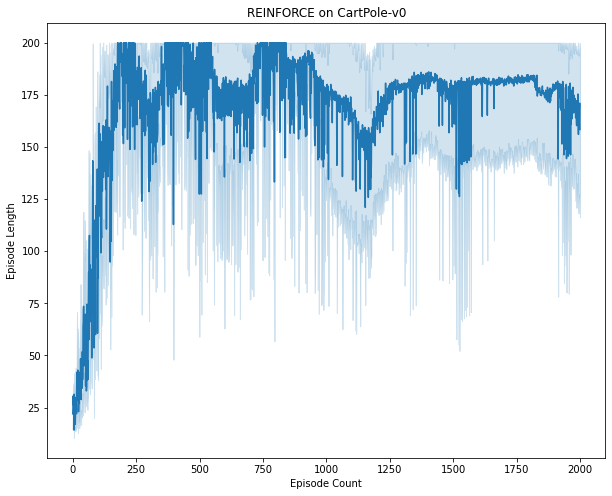

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df = pd.melt(pd.DataFrame(final_score_policy_gradient),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("REINFORCE on CartPole-v0");

### Hyper Parameter Discussion

*Since it takes really long to train, we trained different hyperparameters on copies of the notebook on different accounts.  
Sharing our analysis and plot.*

**Hyper-Parameters**


1.   **Gamma**: It was advised to use 0.9 and we found that 0.99 gives the best results.
2.   **Hidden Size**: We tried different hidden sizes like 16, 32, 64, 128 and 64 gives the best results.
3.   **Learning Rate**: Tried learning rates like 0.1,0.01,0.001,0.0001. Analysed that a high learning rate quickly converges but then it can reduce the reward in later stage. Whereas a smaller learning rate converges slowly but the results dont vary a lot. We fixed a learning rate of 0.01 with Adam optimizer.

Interesting results for different hyper-params shared in the below image


In [0]:
import IPython
IPython.display.HTML('<img src="https://drive.google.com/uc?id=1QtmfZUaAnj88XHoxbQcIysHzoejuRxVb", width=800 height=350>')

### Observation

As expected, the Monte Carlo methods give good results and the model quiclly seems to be converging but as evident in the plot, it has a lot of variance. Since it used discounted rewards till the end of the episode, which gives a good estimate of the reward and the model converges after 500 episodes. This variance would have been even more if the updates were made after every episode. The batch updates did improve the variance to some extent. 

# Actor-Critic 

## Algorithm

Input a differentiable policy parameterization $\pi(a \mid s, \theta_{\pi})$  
Input a differentiable state-value parameterization $\hat{v}(s, \theta_{\hat{v}})$  
Select step-size parameters $0 < \alpha_{\pi}, \alpha_{\hat{v}} \leq 1$  
Initialize the parameters $\theta_{pi}$, $\theta_{\hat{v}}$  
Loop through $n$ episodes:  
Begin the episode $s_0$  
Continue to loop until the episode ends:  
Get action $A_t$ from $\pi$: $\pi(S_t, \theta_{\pi}) \rightarrow A_t$.  
Take action $A_t$ and observe reward ($R_t$) and the new state ($S_{t+1}$)  
Calculate the TD target: $G_t \leftarrow R_t + \gamma \hat{v}(S_{t+1}, \theta_{\hat{v}})$  
Calculate the TD error: $\delta_t \leftarrow R_t + \gamma \hat{v}(S_{t+1},   \theta_{\hat{v}}) – \hat{v}(S_t, \theta_{\hat{v}})$  
Calculate the critic loss $L(\theta_{\hat{v}}) =
\frac{1}{T}\sum_{t=1}^T \big(\hat{v}(S_t, \theta_{\hat{v}}) – G_t \big)^2$  
Calculate the actor loss $L(\theta_{\pi}) = -\sum_{t=1}^T ln \big(\pi(A_t \mid S_t, \theta_{pi}) \big)\delta_t$  
Update actor parameters through backpropagation: $\theta_{\pi} := \theta_{\pi} + \alpha_{\pi} \nabla_{\pi} L(\theta_{\pi})$  
Update critic parameters through backpropagation: $\theta_{\hat{v}} := \theta_{\hat{v}} + \alpha_{\hat{v}} \nabla_{\hat{v}} L(\theta_{\hat{v}})$

## Code

*Practically, few changes were made in the above algorithm to implement this.*   

*   Used cross entropy loss for negative log likelihood and weighted it with the td_error for the actor.
*   Even though we dont need to wait till the end of the episode since it is a one step TD but we used a batch of episodes/steps to make the update instead of updating every step. (This added stability to the model) 


In [0]:
class Base():
  def init_grad_memory(self):
    grad_memory = self.model.trainable_variables
    for i, grad in enumerate(grad_memory):
      grad_memory[i] = grad * 0
    return grad_memory

class Actor(Base):
  def __init__(self, hidden_size, lr):
    self.model = tf.keras.Sequential()
    for i in range(len(hidden_size)):
      self.model.add(tf.keras.layers.Dense(hidden_size[i], input_dim = 4, activation='relu', dtype='float64' ))
    self.model.add(tf.keras.layers.Dense(2, dtype='float64'))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    self.model.build()

  def compute_loss(self, selected_action, logits, td_error):
    actions_one_hot = tf.one_hot([selected_action], 2)
    negative_loglikelihoods = tf.nn.softmax_cross_entropy_with_logits(labels=actions_one_hot, logits=logits)
    weighted_negative_loglikelihoods = tf.math.multiply(negative_loglikelihoods, td_error)
    loss = tf.reduce_sum(weighted_negative_loglikelihoods)
    return loss

class Critic(Base):
  def __init__(self, hidden_size, lr):
    self.model = tf.keras.Sequential()
    for i in range(len(hidden_size)):
      self.model.add(tf.keras.layers.Dense(hidden_size[i], input_dim = 4, activation='relu', dtype='float64'))
    self.model.add(tf.keras.layers.Dense(1, dtype='float64'))
    self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    self.compute_loss = tf.keras.losses.MeanSquaredError()
    self.model.build()

In [0]:
def actor_critic(seed, actor, critic, n_episodes, gamma, batch_size):
  
  env = gym.make('CartPole-v0')
  
  # Set seeds
  tf.random.set_seed(seed)
  np.random.seed(seed)
  env.seed(seed)

  actor_grad_memory = actor.init_grad_memory()
  critic_grad_memory = critic.init_grad_memory()
  e_scores = []

  for episodes in range(n_episodes):
    s_curr = env.reset()
    
    memory = []
    cum_score = 0
    done = False 
    while not done: 
      s_curr = s_curr.reshape([1,4])
      with tf.GradientTape(persistent=True) as tape:
        #Action from Actor
        logits = actor.model(s_curr)
        probs = tf.nn.softmax(logits)
        selected_action = np.random.choice(2, p=probs.numpy()[0])

        #Value function from Critic
        v_s_curr = critic.model(s_curr)

        #Take step with Actor's selected action. 
        s_new, r, done, _ = env.step(selected_action)

        #Adjust true value function with prediction by Critic 
        s_new = s_new.reshape([1,4])

        #The target is the sum of the reward recieved 
        #plus the discounted, predicted reward of the new state
        v_s_new = critic.model(s_new)
        td_target = r + gamma*v_s_new
        td_error = td_target - v_s_curr
        critic_loss = critic.compute_loss(y_true=td_target,
                                          y_pred=v_s_curr)
        actor_loss = actor.compute_loss(selected_action, logits, td_error)


      s_curr = s_new
      cum_score += r

      actor_grads = tape.gradient(actor_loss, actor.model.trainable_variables)
      critic_grads = tape.gradient(critic_loss, critic.model.trainable_variables)
      memory.append([actor_grads, critic_grads])

    e_scores.append(cum_score)
    
    for actor_grads, critic_grads in memory:
      for i, grad in enumerate(actor_grads):
        actor_grad_memory[i] += grad  
      for i, grad in enumerate(critic_grads):
        critic_grad_memory[i] += grad 
    
    if episodes % batch_size == 0:
      actor.optimizer.apply_gradients(zip(actor_grad_memory,
                                        actor.model.trainable_variables))
      critic.optimizer.apply_gradients(zip(critic_grad_memory,
                                        critic.model.trainable_variables))

      actor_grad_memory = actor.init_grad_memory()
      critic_grad_memory = critic.init_grad_memory()

    if episodes % 100 == 0:
      print("Episode  {}  Score  {}".format(episodes, np.mean(e_scores[-100:])))
  
  return e_scores

## Experiments

In [0]:
final_score_actor_critic = []
for i in [1, 100, 345, 768, 123]:
  actor = Actor(hidden_size=[64], lr=0.01)
  critic = Critic(hidden_size=[64], lr=0.01)
  print("Seed", i)
  score = actor_critic(i, actor, critic, n_episodes=2000, gamma=0.99, batch_size=5)
  final_score_actor_critic.append(score)

Seed 1
Episode  0  Score  13.0
Episode  100  Score  19.29
Episode  200  Score  23.38
Episode  300  Score  49.6
Episode  400  Score  63.56
Episode  500  Score  63.88
Episode  600  Score  48.51
Episode  700  Score  54.61
Episode  800  Score  67.32
Episode  900  Score  54.01
Episode  1000  Score  37.87
Episode  1100  Score  37.69
Episode  1200  Score  51.28
Episode  1300  Score  95.07
Episode  1400  Score  71.24
Episode  1500  Score  46.71
Episode  1600  Score  46.86
Episode  1700  Score  56.46
Episode  1800  Score  73.91
Episode  1900  Score  134.6
Seed 100
Episode  0  Score  32.0
Episode  100  Score  38.12
Episode  200  Score  61.35
Episode  300  Score  73.94
Episode  400  Score  83.98
Episode  500  Score  69.05
Episode  600  Score  40.09
Episode  700  Score  44.33
Episode  800  Score  55.49
Episode  900  Score  76.47
Episode  1000  Score  54.34
Episode  1100  Score  38.21
Episode  1200  Score  40.71
Episode  1300  Score  54.66
Episode  1400  Score  78.45
Episode  1500  Score  76.52
Epi

### Graph

The graph is plotted on the below selected hyper-params - Same as REINFORCE  
**Gamma = 0.99, Learning Rate = 0.01, Optimizer=Adam, Hidden Size=64, Layers=1 hidden, Updated Every 5 episodes**


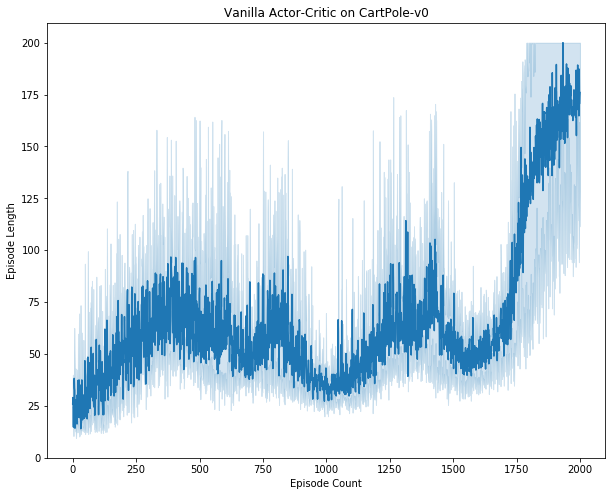

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df = pd.melt(pd.DataFrame(final_score_actor_critic),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df)
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("Vanilla Actor-Critic on CartPole-v0");

### Hyper Parameter Discussion

*Since it takes really long to train, we trained different hyperparameters on copies of the notebook on different accounts.  
Sharing our analysis and plot.*

To compare the REINFORCE algorithm with Actor-Critic, we sticked to the same hyperaparamters as in the REINFORCE algorithm to have a fair comparison. Although we did try different hyper-parameters and inspite of better results, we sticked to the same hyper-param as in REINFORCE.  

**Hyper-Parameters**


1.   **Gamma**: It was advised to use 0.9 and the actor-critic simply fails to converge and we found that 0.99 gives the best results.
2.   **Hidden Size**: We tried different hidden sizes like 16, 32, 64, 128 and 128 gives good result.
3.   **Learning Rate**: Tried learning rates like 0.1,0.01,0.001,0.0001. Analysed that setting e good learning rate is really difficult and it requires a lot many experiments. We fixed a learning rate of 0.01 with Adam optimizer.
4. **Batch Size**: Interesting Finding - We analysed that a higher batch size does not perform good on 1-step actor-critic. Although it reduced the variances but it converges quite late. Updating after every episode seems to perform better than updating after 5 episodes like in Reinforce. This could be because bootstrap itself adds lot of bias and updating in batch add more bias to the problem. Moreover, we dont have a high variance problem like in REINFORCE, hence we can stick to a small updates. 

Interesting results for different updating strategy shared in the below image. All the other hyper-params were kept consistent to the one tried in REINFORCE.



In [0]:
import IPython
IPython.display.HTML('<img src="https://drive.google.com/uc?id=15TKKRqJZAHia1Fl29rslbBbS6FaFqV2h", width=900 height=600>')

### Observation

Doing away with the MC targets and using a critic function to approximate does reduce the variance but seems to add a lot of noise. The one-step vannila actor-critic method doesnt perform better than REINFORCE in our experiments(or is at par with REINFORCE if updated quickly). This does make sense because bootstrapping from just one step will add lot of bias in the network and make it difficult to converge. However changing one-step to n-step method should surely improve the performance of the actor-critic method.  

# Comparing REINFORCE vs One-step Actor Critic 

## Graph 1

The graph below is compared with **REINFORCE with 1-step actor critic both 
updated after every 5 episodes)**

Text(0.5, 1.0, 'Reinforce VS Actor-Critic on CartPole-v0')

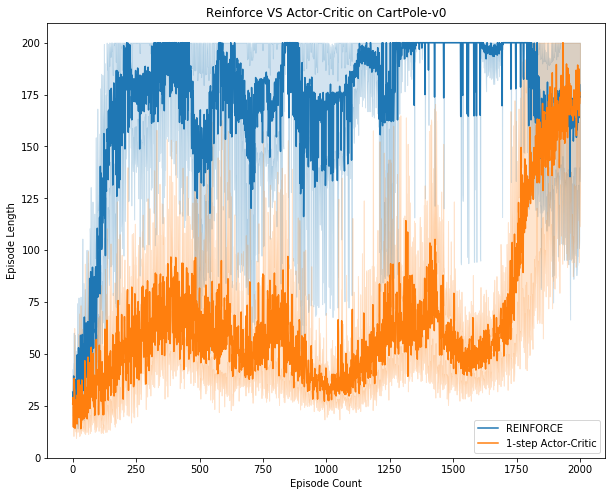

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df_reinforce = pd.melt(pd.DataFrame(final_score_policy_gradient),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df_reinforce)

df_actor_critic = pd.melt(pd.DataFrame(final_score_actor_critic_2),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df_actor_critic, )
plt.legend(['REINFORCE', '1-step Actor-Critic'])
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("Reinforce VS Actor-Critic on CartPole-v0")

## Graph 2

The graph below is compared with **REINFORCE (updated after every 5 episodes) and 1-step Actor-Critic (updated every step as in theory)**

Text(0.5, 1.0, 'Reinforce VS Actor-Critic on CartPole-v0')

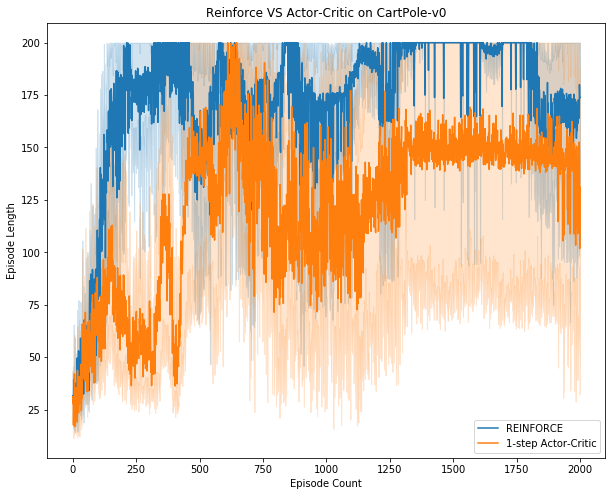

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
df_reinforce = pd.melt(pd.DataFrame(final_score_policy_gradient),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df_reinforce)

df_actor_critic = pd.melt(pd.DataFrame(final_score_actor_critic),
            var_name="variable", value_name="value")
sns.lineplot(x='variable', y='value', 
            data=df_actor_critic, )
plt.legend(['REINFORCE', '1-step Actor-Critic'])
plt.xlabel("Episode Count")
plt.ylabel("Episode Length")
plt.title("Reinforce VS Actor-Critic on CartPole-v0")

## Final Observations

Policy Gradient (REINFORCE) calculates rewards till the end of the episode and hence do not approximate the returns and give good solid returns. Due to this, the algorithm converges in less than 500 episodes. Due to the variance by discounted returns till the end because each trajectories during training can deviate from each other at great degrees, the gradients are really noisy and we need a really large batch of updates to make it more stable. Finding a good learning rate is really painful and methods like ADAM dont really outperform like they do in supervised settings. There	exist	algorithms	that	adjust	the	gradient	stepsize to	obtain more stability, such	as Trust-Region	Policy Optimization	(TRPO) and Proximal	Policy Optimization.

1 step Actor-Critic is an improvement over the policy gradient algorithm with a slight modification where the returns are 1-step TD returns predicted from a critic network that also learns to improve its prediction. This bootstrapped returns do add bias in the network alongwith reducing the variance in the Monte Carlo. Here we compared both the cases where the updated in 1-step actor critic is actually made after every step and the one where the losses are stored and all updated after a set few episodes. There are many different versions of actor-critic that will perform better than REINFORCE. This however was a vanilla actor-critic as suggested in the book. Ideally adding few more things to the actor-critic model will help it exceed the REINFORCE model like using a n-step actor critic, adding entropy loss in the actor loss, using Generalized Advantage Estimation (GAE) using eligibility traces, advantage actor-critic, asynchronous actor critic, etc.



# References

*   [Reinforcement Learning Book](http://incompleteideas.net/book/the-book-2nd.html)
*   [UCB Lecture on REINFORCE](https://web.stanford.edu/class/cs20si/lectures/CS20_intro_to_RL.pdf)
*   [UCB Lecture on Actor-Critic](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf)
*   [Coding Reference 1](https://github.com/dennybritz/reinforcement-learning)
*   [Coding Reference 2](https://www.datahubbs.com/policy-gradients-and-advantage-actor-critic/)
*   [Actor-critic Tensorflow Tutorial](https://blog.tensorflow.org/2018/07/deep-reinforcement-learning-keras-eager-execution.html)


